
# Project: Investigate a Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This dataset is in the form of sqlite database, it has serveral tables, some of them just linking IDs with names, and others contain thousands of rows of data.
The database has data about matches, teams, and players for a time span starts from season 2008/2009 till 2015/2016
in this analysis we will try to answer the following question:
- What teams improved the most over the time period?
- What team attributes lead to the most victories?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
% matplotlib inline
import seaborn as sns

In [2]:
con = sqlite3.connect('database.sqlite')
cursor = con.cursor()

<a id='wrangling'></a>
## Data Wrangling


### General Properties

Let's see what tables we have in this database

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


After consulting [database documentation](https://www.kaggle.com/hugomathien/soccer), we will focus on 3 database tables:
- Match
- Team
- Team_Attributes

Let's load them into dataframes then close the connection.

In [4]:
df_matches = pd.read_sql_query('Select * From Match', con)
df_matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [5]:
df_team = pd.read_sql_query('select * From Team', con)
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [6]:
df_attribs = pd.read_sql_query('select * From Team_Attributes', con)
df_attribs.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


Let's now dig deeper into the three dataframes

In [7]:
df_matches.columns.values

array(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2',
       'away_player_X3', 'away_player_X4', 'away_player_X5',
       'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
       'home_player_Y10', 'home_player_Y11', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'aw

I have checked the [discussion](https://www.kaggle.com/hugomathien/soccer/discussion) page of this database to know the meaning of table names, some of them are related to player position on the play ground, events specific to each match, and betting odds. We will not use them in our analysis. So we will drop them.

In [8]:
df_matches.drop(['id', 'country_id', 'league_id', 'stage', 'date',
        'match_api_id','home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2',
       'away_player_X3', 'away_player_X4', 'away_player_X5',
       'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
       'home_player_Y10', 'home_player_Y11', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'away_player_Y8', 'away_player_Y9', 'away_player_Y10',
       'away_player_Y11', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11', 'away_player_1',
       'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
       'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
       'away_player_10', 'away_player_11','goal', 'shoton', 'shotoff',
       'foulcommit', 'card', 'cross', 'corner', 'possession','B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
       'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH',
       'BSD', 'BSA'], axis=1, inplace=True)

In [9]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 5 columns):
season              25979 non-null object
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(4), object(1)
memory usage: 1014.9+ KB


No missing data, data types look proper.

Close the connection

In [10]:
con.close()

## Preparing data to measure improvement and study most victories attributes

### Road map

1. We will add a column with game result: home wins, away wins or draw.
1. We will then split each match row into two rows, one for each team. The new rows will include:
    - Team
    - Season
    - Match result for the team: win, lose or draw
    - team goals
    - oponent goals
    - match type: home or away
1. We will merge the above dataframe with the attributes dataframe based on Team and season, so now we will have selected attributes added to each row.
1. We will replace team ids with team names from 'Team' table to give more meaning to team statistics.
1. We will add a new column to team statistics called period, where we will divide rows into two periods. All rows with season up to 2011/2012 will be considered old, and whatever after will be considered recent.
1. We will aggregate data grouped by period and team to sum wins, losses and draws, team goals and oponent goals.
1. We will calculate a score, based on the number of wins, draws and losses, for each period to quantify the performance.
1. We will then split the dataframe into two dataframes, one for each period.
1. We will then merge the two dataframes by team to have old and new scores for the same team to calculate the difference and get the best improvment.
1. Explore the data to answer questions.

### 1. Adding Game Result Column:

First we need to add a new column to df_match with match result based on 'home_team_goal' and 'away_team_goal'

In [11]:
def result(x):
    if x['home_team_goal'] > x['away_team_goal']:
        full_time_res = 'home wins'
    elif x['home_team_goal'] == x['away_team_goal']:
        full_time_res = 'draw'
    else:
        full_time_res = 'away wins'
    return full_time_res

In [12]:
df_matches['full_time_result'] = df_matches.apply(lambda x: result(x), axis=1)

In [13]:
df_matches.head()

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,full_time_result
0,2008/2009,9987,9993,1,1,draw
1,2008/2009,10000,9994,0,0,draw
2,2008/2009,9984,8635,0,3,away wins
3,2008/2009,9991,9998,5,0,home wins
4,2008/2009,7947,9985,1,3,away wins


### 2. Split each match data into two rows with team and result for the team

To split each match row into two different team rows, we will need to copy subsets of df_match, each filtered by game result. That process will be repeated six times to collect the three possible match results (home wins, away wins, and draw) for home team once, then for the away team.

It is wise to use a function in this case.

In [14]:
def fetch_team(final_result, keep, game_result):
    
    """
    This function produces a dataframe with only one team name instead of 2, and the match
    result for that team(win, lose, draw), it also rename column to have an ouput with
    standard format.

    Parameters:
        final_result: when the value of 'full_time_result' matches this parameter, the
        row is included in the returned dataframe. possible values are (home wins, away wins, draw)
        keep: Usual one of two values;'home_team' or 'away team'. They represent two
        column names. The column that has a name matches this paramter will be renamed to
        'team' and the other column will be dropped.
        game_result: is the result of the match for the team we are keeping (win, lose, draw)
    
    Returns:
        dataframe with a column called 'team' contains team name, and a column called 'result'
        contains the result for that team.
    """
    #create a copy of the filtered df_matches
    returned_df=df_matches[df_matches['full_time_result']==final_result].copy()
    #set the names of columns to keep and to drop
    if keep == 'home_team_api_id':
        drop_column = 'away_team_api_id'
        home_goals = 'team_goals'
        away_goals = 'oponent_goals'
    else:
        drop_column='home_team_api_id'
        home_goals = 'oponent_goals'
        away_goals = 'team_goals'
    #drop the other team column
    returned_df.drop([drop_column],axis=1,inplace=True)
    
    #change the column names to have a standard format
    #'team' will be the name of the column that has the team we are keeping
    #'team_goals' will be the name of team goals.
    #'oponent_goals' will be the name oponent goals.
    new_names = {keep:'team', 'home_team_goal':home_goals, 'away_team_goal': away_goals}
    returned_df.rename(columns=new_names,inplace=True)
    #add columns with match result and game type
    returned_df['game_result']=np.repeat(game_result, returned_df.shape[0])
    return returned_df

We can now use the above function to creat the six subdataframes. Their total row count should be double that the rows of *df_match*

In [15]:
home_wins = fetch_team('home wins','home_team_api_id','win')
home_loses = fetch_team('away wins','home_team_api_id','lose')
away_wins = fetch_team('away wins','away_team_api_id','win')
away_loses = fetch_team('home wins','away_team_api_id','lose')
home_draw = fetch_team('draw','home_team_api_id','draw')
away_draw = fetch_team('draw','away_team_api_id','draw')

In [16]:
(df_matches.shape[0]*2 == home_draw.shape[0] + home_loses.shape[0] 
 + home_wins.shape[0] + away_draw.shape[0] + away_loses.shape[0] + away_wins.shape[0])

True

In [17]:
home_loses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7466 entries, 2 to 25975
Data columns (total 6 columns):
season              7466 non-null object
team                7466 non-null int64
team_goals          7466 non-null int64
oponent_goals       7466 non-null int64
full_time_result    7466 non-null object
game_result         7466 non-null object
dtypes: int64(3), object(3)
memory usage: 408.3+ KB


Now we will group each of the previous 6 dataframes by season and team, and aggregate with summing *team_goals* and *oponent_goals*, and counting *game_result*.

Let's make a function that handles the repeating work.

In [18]:
def get_df_stats(df, game_type_name, game_result_name):
    """creats a new dataframe by grouping another dataframe by certian columns and
    aggregating other columns
    
    Parameters:
        df: input dataframe to be processed
        game_result_name: the name that will be used for the count of game result column
        in the returned data frame. It can have one of three values (win, loss, draw)
        The column has to be renamed merging later.
        game_type_name: the name of a new column that will hold the count of game
        result, it can have one of two values (home, away). As we are feeding a dataframe
        with just one game type and one game result, game type and game result counts will
        be identical. But later each will have its own role.
        
    Returns:
        New dataframe with count of game result and game type and sum of team goals and
        openent goals per team per season. column names will reflect game type and game
        result for future merge.
    
    """
    groupby_columns = ['season', 'team']
    aggeragtion_parameters = {'game_result':'count',
                              'team_goals':'sum', 'oponent_goals':'sum'}
    new_names = {'game_result':game_result_name}
    return_df = df.groupby(groupby_columns).agg(aggeragtion_parameters).reset_index()
    return_df.rename(columns=new_names, inplace=True)
    return_df[game_type_name]=return_df[game_result_name]
    return return_df
    

In [19]:
h_wins_stats = get_df_stats(home_wins, 'home', 'win')
h_loses_stats = get_df_stats(home_loses, 'home', 'loss')
h_draws_stats = get_df_stats(home_draw, 'home', 'draw')
a_wins_stats = get_df_stats(away_wins, 'away', 'win')
a_loses_stats = get_df_stats(away_loses, 'away', 'loss')
a_draws_stats = get_df_stats(away_draw, 'away', 'draw')

In [20]:
h_draws_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 6 columns):
season           1459 non-null object
team             1459 non-null int64
draw             1459 non-null int64
team_goals       1459 non-null int64
oponent_goals    1459 non-null int64
home             1459 non-null int64
dtypes: int64(5), object(1)
memory usage: 68.5+ KB


In [21]:
a_draws_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 6 columns):
season           1462 non-null object
team             1462 non-null int64
draw             1462 non-null int64
team_goals       1462 non-null int64
oponent_goals    1462 non-null int64
away             1462 non-null int64
dtypes: int64(5), object(1)
memory usage: 68.6+ KB


It is clear that number of season/team pairs will be not identical, for example the two dataframes above show that there are more season/team pairs that have had draws home than those have draws away.

This should introduce some null values when merging, but we can replace them with 0.

Now let's merge data on three steps, starting with wins then loss then draws.

While doing so we will fill nulls with 0, and we will sum similar columns.

In [22]:
wins_stats = pd.concat([h_wins_stats, a_wins_stats], sort=False).fillna(0).groupby(
    ['season', 'team'])['win', 'team_goals', 'oponent_goals', 'home', 'away'].sum().reset_index()
wins_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 7 columns):
season           1481 non-null object
team             1481 non-null int64
win              1481 non-null int64
team_goals       1481 non-null int64
oponent_goals    1481 non-null int64
home             1481 non-null float64
away             1481 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 81.1+ KB


In [23]:
losses_stats = pd.concat([h_loses_stats, a_loses_stats], sort=False).fillna(0).groupby(
    ['season', 'team'])['loss', 'team_goals', 'oponent_goals', 'home', 'away'].sum().reset_index()
losses_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 7 columns):
season           1477 non-null object
team             1477 non-null int64
loss             1477 non-null int64
team_goals       1477 non-null int64
oponent_goals    1477 non-null int64
home             1477 non-null float64
away             1477 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 80.9+ KB


In [24]:
draws_stats = pd.concat([h_draws_stats, a_draws_stats], sort=False).fillna(0).groupby(
    ['season', 'team'])['draw', 'team_goals', 'oponent_goals', 'home', 'away'].sum().reset_index()
draws_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479 entries, 0 to 1478
Data columns (total 7 columns):
season           1479 non-null object
team             1479 non-null int64
draw             1479 non-null int64
team_goals       1479 non-null int64
oponent_goals    1479 non-null int64
home             1479 non-null float64
away             1479 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 81.0+ KB


Now let's merge those last three dataframes

In [25]:
wins_losses_stats = pd.concat([wins_stats, losses_stats], sort=False).fillna(0).groupby(
    ['season', 'team'])['win', 'loss', 'team_goals', 'oponent_goals', 'home', 'away'].sum().reset_index()
wins_losses_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 8 columns):
season           1481 non-null object
team             1481 non-null int64
win              1481 non-null float64
loss             1481 non-null float64
team_goals       1481 non-null int64
oponent_goals    1481 non-null int64
home             1481 non-null float64
away             1481 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 92.6+ KB


In [26]:
team_stats = pd.concat([wins_losses_stats, draws_stats], sort=False).fillna(0).groupby(
    ['season', 'team'])['win', 'loss', 'draw', 'team_goals', 'oponent_goals', 'home', 'away'].sum().reset_index()
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 9 columns):
season           1481 non-null object
team             1481 non-null int64
win              1481 non-null float64
loss             1481 non-null float64
draw             1481 non-null float64
team_goals       1481 non-null int64
oponent_goals    1481 non-null int64
home             1481 non-null float64
away             1481 non-null float64
dtypes: float64(5), int64(3), object(1)
memory usage: 104.2+ KB


In [27]:
team_stats.head()

,season,team,win,loss,draw,team_goals,oponent_goals,home,away
0,2008/2009,1601,9.0,14.0,7.0,22,32,15.0,15.0
1,2008/2009,1957,9.0,14.0,7.0,28,34,15.0,15.0
2,2008/2009,2182,16.0,3.0,11.0,51,24,15.0,15.0
3,2008/2009,2183,15.0,6.0,9.0,40,23,15.0,15.0
4,2008/2009,2186,7.0,14.0,9.0,24,40,15.0,15.0


## 3. Merging with attributes

Now let's have a look on df_attribs dataframe

In [28]:
df_attribs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
id                                1458 non-null int64
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreationShootin

For the sake of our analysis we will keep Class attributes, date and team_id

In [29]:
for c in df_attribs.columns.values:
    if 'Class' in c:
        df_attribs.drop(c, axis=1, inplace=True)
df_attribs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 13 columns):
id                        1458 non-null int64
team_fifa_api_id          1458 non-null int64
team_api_id               1458 non-null int64
date                      1458 non-null object
buildUpPlaySpeed          1458 non-null int64
buildUpPlayDribbling      489 non-null float64
buildUpPlayPassing        1458 non-null int64
chanceCreationPassing     1458 non-null int64
chanceCreationCrossing    1458 non-null int64
chanceCreationShooting    1458 non-null int64
defencePressure           1458 non-null int64
defenceAggression         1458 non-null int64
defenceTeamWidth          1458 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 148.2+ KB


No null values.


Now we need to convert the date column into a season, in order to do so we will need to convert date columns into date datatype.

We can then extract year and month, and assign a season for each record.

If the month was in the first half of the year, season will be year-1/year, and if not season will be year/year+1.

In [30]:
df_attribs['date']=pd.to_datetime(df_attribs['date'])

In [31]:
df_attribs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 13 columns):
id                        1458 non-null int64
team_fifa_api_id          1458 non-null int64
team_api_id               1458 non-null int64
date                      1458 non-null datetime64[ns]
buildUpPlaySpeed          1458 non-null int64
buildUpPlayDribbling      489 non-null float64
buildUpPlayPassing        1458 non-null int64
chanceCreationPassing     1458 non-null int64
chanceCreationCrossing    1458 non-null int64
chanceCreationShooting    1458 non-null int64
defencePressure           1458 non-null int64
defenceAggression         1458 non-null int64
defenceTeamWidth          1458 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(11)
memory usage: 148.2 KB


In [32]:
df_attribs['year'] = df_attribs['date'].dt.year

In [33]:
df_attribs['month'] = df_attribs['date'].dt.month

In [34]:
df_attribs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 15 columns):
id                        1458 non-null int64
team_fifa_api_id          1458 non-null int64
team_api_id               1458 non-null int64
date                      1458 non-null datetime64[ns]
buildUpPlaySpeed          1458 non-null int64
buildUpPlayDribbling      489 non-null float64
buildUpPlayPassing        1458 non-null int64
chanceCreationPassing     1458 non-null int64
chanceCreationCrossing    1458 non-null int64
chanceCreationShooting    1458 non-null int64
defencePressure           1458 non-null int64
defenceAggression         1458 non-null int64
defenceTeamWidth          1458 non-null int64
year                      1458 non-null int64
month                     1458 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(13)
memory usage: 170.9 KB


Now to merge with match_stats dataframe, we will need to convert the month and date to season

In [35]:
def set_season(x):
    if x.month > 6:
        season = str(x.year) + "/" + str(x.year+1)
    else:
        season = str(x.year-1) + "/" +str(x.year)
    return season

In [36]:
df_attribs['season'] = df_attribs.apply(lambda x: set_season(x), axis=1)

In [37]:
df_attribs['season'].value_counts()

2015/2016    245
2014/2015    244
2010/2011    244
2011/2012    242
2013/2014    242
2009/2010    241
Name: season, dtype: int64

We can see there are missing seasons in this dataframe

In [38]:
df_attribs.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,year,month,season
0,1,434,9930,2010-02-22,60,NaN,50,60,65,55,50,55,45,2010,2,2009/2010
1,2,434,9930,2014-09-19,52,48.0,56,54,63,64,47,44,54,2014,9,2014/2015
2,3,434,9930,2015-09-10,47,41.0,54,54,63,64,47,44,54,2015,9,2015/2016
3,4,77,8485,2010-02-22,70,NaN,70,70,70,70,60,70,70,2010,2,2009/2010
4,5,77,8485,2011-02-22,47,NaN,52,53,48,52,47,47,52,2011,2,2010/2011


In [39]:
df_attribs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 16 columns):
id                        1458 non-null int64
team_fifa_api_id          1458 non-null int64
team_api_id               1458 non-null int64
date                      1458 non-null datetime64[ns]
buildUpPlaySpeed          1458 non-null int64
buildUpPlayDribbling      489 non-null float64
buildUpPlayPassing        1458 non-null int64
chanceCreationPassing     1458 non-null int64
chanceCreationCrossing    1458 non-null int64
chanceCreationShooting    1458 non-null int64
defencePressure           1458 non-null int64
defenceAggression         1458 non-null int64
defenceTeamWidth          1458 non-null int64
year                      1458 non-null int64
month                     1458 non-null int64
season                    1458 non-null object
dtypes: datetime64[ns](1), float64(1), int64(13), object(1)
memory usage: 182.3+ KB


We will do a left merge to df_attribs to have a dataframe with attributes and winnings stats, but let's drop the redundant columns frist.

In [40]:
df_attribs.drop(['id', 'team_fifa_api_id', 'date', 'year', 'month'], axis=1, inplace=True)

In [41]:
df_attribs.rename(columns={'team_api_id':'team'}, inplace=True)

In [42]:
attribs_stats = df_attribs.merge(team_stats, on=['season', 'team'], how='left')

In [43]:
attribs_stats.head()

,team,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,season,win,loss,draw,team_goals,oponent_goals,home,away
0,9930,60,NaN,50,60,65,55,50,55,45,2009/2010,6.0,25.0,5.0,32.0,88.0,18.0,18.0
1,9930,52,48.0,56,54,63,64,47,44,54,2014/2015,6.0,18.0,12.0,31.0,64.0,18.0,18.0
2,9930,47,41.0,54,54,63,64,47,44,54,2015/2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8485,70,NaN,70,70,70,70,60,70,70,2009/2010,10.0,17.0,11.0,36.0,52.0,20.0,18.0
4,8485,47,NaN,52,53,48,52,47,47,52,2010/2011,11.0,22.0,5.0,39.0,59.0,19.0,19.0


In [44]:
attribs_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1457
Data columns (total 18 columns):
team                      1458 non-null int64
buildUpPlaySpeed          1458 non-null int64
buildUpPlayDribbling      489 non-null float64
buildUpPlayPassing        1458 non-null int64
chanceCreationPassing     1458 non-null int64
chanceCreationCrossing    1458 non-null int64
chanceCreationShooting    1458 non-null int64
defencePressure           1458 non-null int64
defenceAggression         1458 non-null int64
defenceTeamWidth          1458 non-null int64
season                    1458 non-null object
win                       1068 non-null float64
loss                      1068 non-null float64
draw                      1068 non-null float64
team_goals                1068 non-null float64
oponent_goals             1068 non-null float64
home                      1068 non-null float64
away                      1068 non-null float64
dtypes: float64(8), int64(9), object(1)
memory us

let's aslo drop the column buildUpPlayDribbling as it is missing a lot of data

In [45]:
attribs_stats.drop('buildUpPlayDribbling', axis=1, inplace=True)

We can see that there are null values, with a big percentage, so let's just drop the null values to avoid assumptions that may affect the conclusion

In [46]:
attribs_stats.dropna(inplace=True)

In [47]:
attribs_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068 entries, 0 to 1457
Data columns (total 17 columns):
team                      1068 non-null int64
buildUpPlaySpeed          1068 non-null int64
buildUpPlayPassing        1068 non-null int64
chanceCreationPassing     1068 non-null int64
chanceCreationCrossing    1068 non-null int64
chanceCreationShooting    1068 non-null int64
defencePressure           1068 non-null int64
defenceAggression         1068 non-null int64
defenceTeamWidth          1068 non-null int64
season                    1068 non-null object
win                       1068 non-null float64
loss                      1068 non-null float64
draw                      1068 non-null float64
team_goals                1068 non-null float64
oponent_goals             1068 non-null float64
home                      1068 non-null float64
away                      1068 non-null float64
dtypes: float64(7), int64(9), object(1)
memory usage: 150.2+ KB


let's add a column that calculates wining percentage

In [48]:
attribs_stats['win_perc']=attribs_stats.apply(lambda x: x.win / (x.win + x.draw + x.loss), axis=1)

In [49]:
attribs_stats.describe()

,team,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,win,loss,draw,team_goals,oponent_goals,home,away,win_perc
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,9765.209738,52.522472,47.895131,52.444757,53.808989,54.226592,46.521536,49.641386,52.286517,13.237828,13.023408,8.886704,47.909176,47.404494,17.573034,17.574906,0.376679
std,12501.630844,11.996503,11.092702,10.519930,11.215827,10.572159,10.437950,10.029836,9.647310,5.631581,5.175859,2.972743,16.120801,13.264071,1.795888,1.798939,0.155065
min,1601.000000,20.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000,1.000000,0.000000,0.000000,5.000000,6.000000,3.000000,3.000000,0.078947
25%,8472.000000,45.000000,39.000000,46.000000,47.000000,48.750000,39.000000,44.000000,48.000000,9.000000,10.000000,7.000000,37.000000,38.750000,17.000000,17.000000,0.264706
50%,8721.000000,53.000000,49.000000,52.000000,53.000000,54.000000,46.000000,48.500000,52.000000,12.000000,13.000000,9.000000,45.000000,47.000000,18.000000,18.000000,0.342105
75%,9927.000000,63.000000,55.000000,60.000000,63.000000,63.000000,53.000000,57.000000,59.000000,16.000000,17.000000,11.000000,56.000000,56.000000,19.000000,19.000000,0.466667
max,274581.000000,80.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,33.000000,29.000000,19.000000,121.000000,98.000000,20.000000,20.000000,0.900000


We can use the table above to set categories for winning, max_wins, high_wins, low_wins, min_wins

In [50]:
def cat_wins(x):
    if x.win_perc < 0.264706:
        win_cat = 'max_wins'
    elif x.win_perc < 0.342105:
        win_cat = 'med_high_wins'
    elif x.win_perc < 0.466667:
        win_cat = 'med_low_wins'
    else:
        win_cat = 'min_wins'
    return win_cat

In [51]:
attribs_stats['win_cats']=attribs_stats.apply(lambda x: cat_wins(x), axis=1)

In [52]:
attribs_stats['win_cats'].value_counts()

med_low_wins     285
max_wins         271
min_wins         263
med_high_wins    249
Name: win_cats, dtype: int64

In [53]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [54]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 9 columns):
season           1481 non-null object
team             1481 non-null int64
win              1481 non-null float64
loss             1481 non-null float64
draw             1481 non-null float64
team_goals       1481 non-null int64
oponent_goals    1481 non-null int64
home             1481 non-null float64
away             1481 non-null float64
dtypes: float64(5), int64(3), object(1)
memory usage: 104.2+ KB


## 4. Use team names rather than team IDs in *match_statistics*

In [55]:
team_stats=team_stats.merge(df_team[['team_api_id', 'team_long_name']],
                            left_on='team', right_on='team_api_id', how='left')

In [56]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481 entries, 0 to 1480
Data columns (total 11 columns):
season            1481 non-null object
team              1481 non-null int64
win               1481 non-null float64
loss              1481 non-null float64
draw              1481 non-null float64
team_goals        1481 non-null int64
oponent_goals     1481 non-null int64
home              1481 non-null float64
away              1481 non-null float64
team_api_id       1481 non-null int64
team_long_name    1481 non-null object
dtypes: float64(5), int64(4), object(2)
memory usage: 138.8+ KB


We can now drop the ID columns and rename team_long_name to team

In [57]:
team_stats.drop(['team', 'team_api_id'], axis=1, inplace=True)

In [58]:
team_stats.rename(columns={'team_long_name':'team'}, inplace=True)

In [59]:
team_stats.head()

,season,win,loss,draw,team_goals,oponent_goals,home,away,team
0,2008/2009,9.0,14.0,7.0,22,32,15.0,15.0,Ruch Chorzów
1,2008/2009,9.0,14.0,7.0,28,34,15.0,15.0,Jagiellonia Białystok
2,2008/2009,16.0,3.0,11.0,51,24,15.0,15.0,Lech Poznań
3,2008/2009,15.0,6.0,9.0,40,23,15.0,15.0,P. Warszawa
4,2008/2009,7.0,14.0,9.0,24,40,15.0,15.0,Cracovia


In [60]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481 entries, 0 to 1480
Data columns (total 9 columns):
season           1481 non-null object
win              1481 non-null float64
loss             1481 non-null float64
draw             1481 non-null float64
team_goals       1481 non-null int64
oponent_goals    1481 non-null int64
home             1481 non-null float64
away             1481 non-null float64
team             1481 non-null object
dtypes: float64(5), int64(2), object(2)
memory usage: 115.7+ KB


### 5. Add Period Column to divide data into two periods

Let's add another column that set the period, we will have two periods to compare the improvement, seasons 2008/2009 to 2011/2012 will take the value of 1, and season from 2012/2013 to 2015/2016 will take the value of 2

In [61]:
def set_period(x):
    first_period = ['2008/2009', '2009/2010', '2010/2011', '2011/2012']
    season_period = 2
    if x['season'] in first_period:
        season_period = 1
    return season_period

In [62]:
team_stats['period']=team_stats.apply(lambda x: set_period(x), axis=1)

In [63]:
team_stats.tail()

,season,win,loss,draw,team_goals,oponent_goals,home,away,team,period
1476,2015/2016,13.0,6.0,15.0,47,38,17.0,17.0,FC Arouca,2
1477,2015/2016,8.0,13.0,9.0,33,43,15.0,15.0,Termalica Bruk-Bet Nieciecza,2
1478,2015/2016,8.0,20.0,6.0,34,54,17.0,17.0,Tondela,2
1479,2015/2016,9.0,18.0,11.0,37,57,19.0,19.0,Carpi,2
1480,2015/2016,7.0,14.0,9.0,39,51,15.0,15.0,Royal Excel Mouscron,2


In [64]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481 entries, 0 to 1480
Data columns (total 10 columns):
season           1481 non-null object
win              1481 non-null float64
loss             1481 non-null float64
draw             1481 non-null float64
team_goals       1481 non-null int64
oponent_goals    1481 non-null int64
home             1481 non-null float64
away             1481 non-null float64
team             1481 non-null object
period           1481 non-null int64
dtypes: float64(5), int64(3), object(2)
memory usage: 127.3+ KB


## 6. Grouping by Period

Let's now group by 'period' and 'team', and summing and counting the columns as we do that.

In [65]:
groupby_columns = ['period', 'team']
agg_params = {'win':'sum', 'loss':'sum', 'draw':'sum', 
                          'team_goals':'sum', 'home':'sum', 'away': 'sum',
                          'team_goals':'sum', 'oponent_goals':'sum'}

In [66]:
team_period_stats = team_stats.groupby(groupby_columns).agg(agg_params).reset_index()

In [67]:
team_period_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 9 columns):
period           489 non-null int64
team             489 non-null object
win              489 non-null float64
loss             489 non-null float64
draw             489 non-null float64
team_goals       489 non-null int64
home             489 non-null float64
away             489 non-null float64
oponent_goals    489 non-null int64
dtypes: float64(5), int64(3), object(1)
memory usage: 34.5+ KB


## 7. Calculating performance score

We will use here the following formula to calculate performance score: (3 x wins + draws) / (Total matches)

Let's add the score Column

In [68]:
team_period_stats['score'] = team_period_stats.apply(lambda x: 
                                       (x.win*3 + x.draw)/(x.win + x.draw + x.loss), axis=1)

In [69]:
team_period_stats.head()

,period,team,win,loss,draw,team_goals,home,away,oponent_goals,score
0,1,1. FC Kaiserslautern,17.0,33.0,18.0,72,34.0,34.0,105,1.014706
1,1,1. FC Köln,41.0,67.0,28.0,154,68.0,68.0,229,1.110294
2,1,1. FC Nürnberg,33.0,48.0,21.0,117,51.0,51.0,152,1.176471
3,1,1. FSV Mainz 05,39.0,36.0,27.0,135,51.0,51.0,132,1.411765
4,1,AC Ajaccio,9.0,15.0,14.0,40,19.0,19.0,61,1.078947


## 8. Splitting team_period_stats dataframe into two dataframes based on period

In [70]:
period_score_old = team_period_stats[team_period_stats['period']==1][['team', 'score']].copy()

In [71]:
period_score_new = team_period_stats[team_period_stats['period']==2][['team', 'score']].copy()

Let's rename the score columns to be able to differenciate upon merge

In [72]:
period_score_new.rename(columns={'score':'new_score'}, inplace=True)

In [73]:
period_score_old.rename(columns={'score':'old_score'}, inplace=True)

In [74]:
period_score_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 244 to 488
Data columns (total 2 columns):
team         245 non-null object
new_score    245 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


In [75]:
period_score_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 2 columns):
team         244 non-null object
old_score    244 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


## 9. Merging the two old and new scores

In [76]:
compare_score = period_score_new.merge(period_score_old, on=['team'], how='outer')

In [77]:
compare_score[compare_score.isnull().any(axis=1)].shape

(103, 3)

It is clear that we have 103 teams where not participating in both period, we will drop them as we are concerned only with improvements over the period.

In [78]:
compare_score.dropna(inplace=True)

Let's add a column for difference in score

In [79]:
compare_score['improvement'] = compare_score.apply(lambda x: x.new_score - x.old_score, axis=1)

In [80]:
compare_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 244
Data columns (total 4 columns):
team           193 non-null object
new_score      193 non-null float64
old_score      193 non-null float64
improvement    193 non-null float64
dtypes: float64(3), object(1)
memory usage: 7.5+ KB


In [81]:
compare_score.sort_values('improvement', ascending=False, inplace=True)

In [82]:
compare_score.head()

,team,new_score,old_score,improvement
17,Atlético Madrid,2.184211,1.500000,0.684211
149,Paris Saint-Germain,2.309211,1.644737,0.664474
5,AS Monaco,1.894737,1.263158,0.631579
108,Juventus,2.414474,1.785235,0.629239
158,RAEC Mons,1.466667,0.859375,0.607292


<a id='eda'></a>
## Exploratory Data Analysis

>Now let's explore the data we have

In [83]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 6 columns):
season              25979 non-null object
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
full_time_result    25979 non-null object
dtypes: int64(4), object(2)
memory usage: 1.2+ MB


Let's see how playing home or away affect the winning

In [84]:
df_matches.full_time_result.value_counts()/df_matches.shape[0]

home wins    0.458717
away wins    0.287386
draw         0.253897
Name: full_time_result, dtype: float64

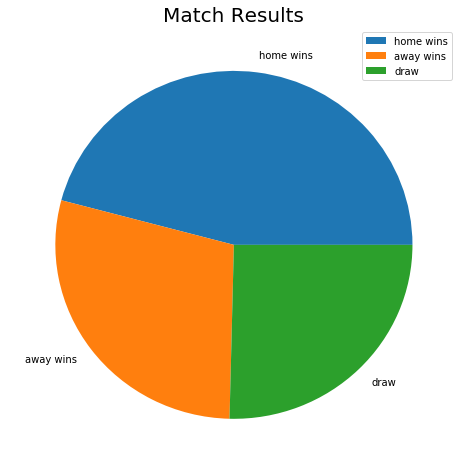

In [85]:
df_matches.full_time_result.value_counts().plot(kind='pie',figsize=(8,8));
plt.title('Match Results',fontsize=20);
plt.legend();
plt.ylabel('');

This pie chart shows the share of each type of match results from total matches in our dataset.

>It is clear that teams tend to win when play in home (about 46% of the time).

>We can see also that about 25% of matches end in draw.

Let's have a look on the relationship between number of goals and playing place.

We will collect means of goals when winning home, winning away, losing home and losing away.


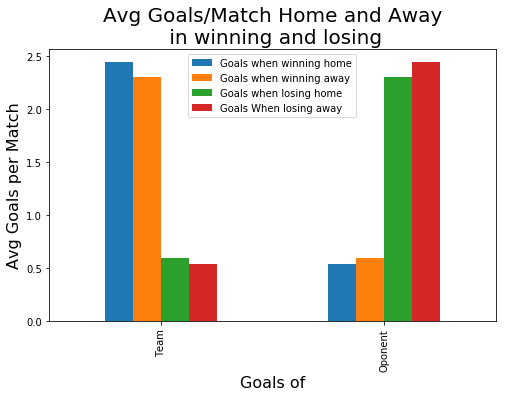

In [86]:
goal_columns=['team_goals', 'oponent_goals']
plot_goals = pd.DataFrame({
    'Goals when winning home':home_wins.mean()[goal_columns].tolist(),
    'Goals when winning away':away_wins.mean()[goal_columns].tolist(),
    'Goals when losing home':home_loses.mean()[goal_columns].tolist(),
    'Goals When losing away':away_loses.mean()[goal_columns].tolist()},
    index=['Team Goals', 'Oponent Goals']
)
ax=plot_goals.plot.bar(figsize=(8, 5));
plt.xlabel('Goals of', fontsize=16);
plt.ylabel('Avg Goals per Match', fontsize=16);
plt.title('Avg Goals/Match Home and Away\n in winning and losing', fontsize=20);
ax.set_xticklabels(['Team', 'Oponent']);


This bar chart compares average goals per match when playing home vs when playing away, for winning games and for losing games.

>It looks like teams tend to socre slightly more when home. in both winning and losing cases.


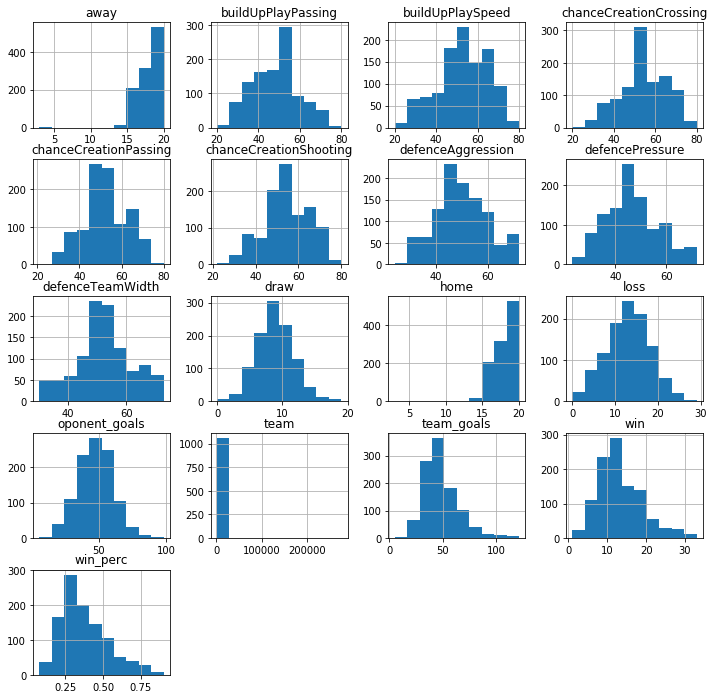

In [87]:
attribs_stats.hist(figsize=(12,12));

What's interesting here that we can see the following following columns skewed to the right:

- Win_perc: wihc represents the winning percentage (of the total matches played)
- Team_goals

On the other hand the following are skewed to the left:

- chanceCreationCrossing: it could indicate that more teams tend to have higher chance creation crossing.

Now let's have a look on the attribs_stats:

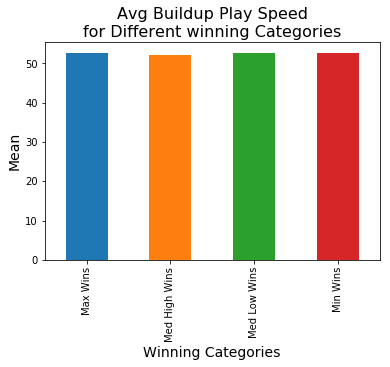

In [88]:
ax = attribs_stats.groupby('win_cats')['buildUpPlaySpeed'].mean().plot(kind='bar');
plt.title('Avg Buildup Play Speed\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Buildup Play Speed for the Different Winning Categories
>No correlation can be seen

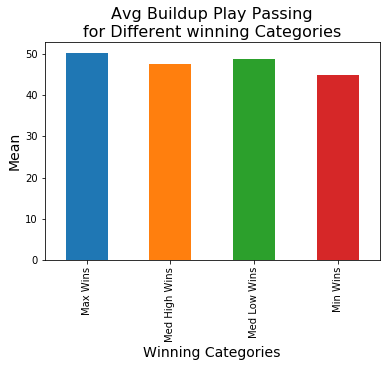

In [89]:
ax = attribs_stats.groupby('win_cats')['buildUpPlayPassing'].mean().plot(kind='bar');
plt.title('Avg Buildup Play Passing\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Buildup Play Passing for the Different Winning Categories
>No correlation can be seen

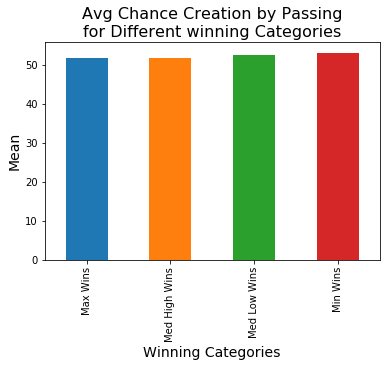

In [90]:
ax = attribs_stats.groupby('win_cats')['chanceCreationPassing'].mean().plot(kind='bar');
plt.title('Avg Chance Creation by Passing\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Chance Creation by Passing for the Different Winning Categories
>No correlation can be seen

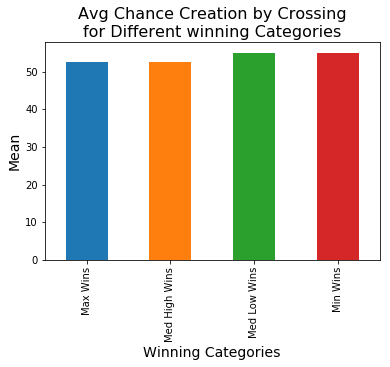

In [91]:
ax = attribs_stats.groupby('win_cats')['chanceCreationCrossing'].mean().plot(kind='bar');
plt.title('Avg Chance Creation by Crossing\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Chance Creation by Crossing for the Different Winning Categories
>Clear inverse correlation!

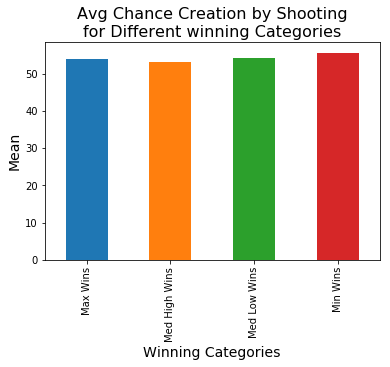

In [92]:
ax = attribs_stats.groupby('win_cats')['chanceCreationShooting'].mean().plot(kind='bar');
plt.title('Avg Chance Creation by Shooting\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Chance Creation by Shooting for the Different Winning Categories
>No correlation can be seen

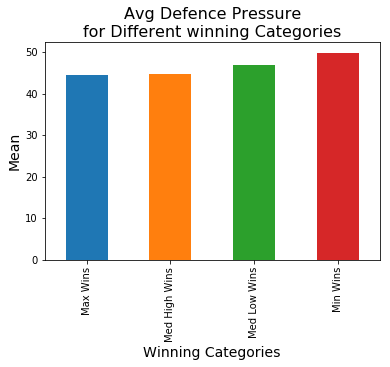

In [93]:
ax = attribs_stats.groupby('win_cats')['defencePressure'].mean().plot(kind='bar');
plt.title('Avg Defence Pressure\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Defence Pressure for the Different Winning Categories
>Clear inverse correlation!

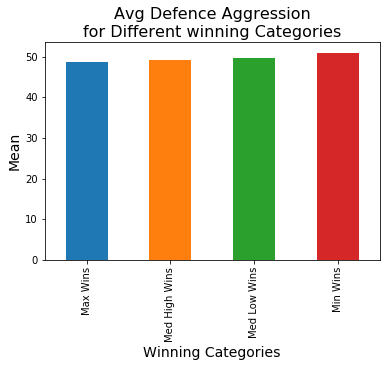

In [94]:
ax = attribs_stats.groupby('win_cats')['defenceAggression'].mean().plot(kind='bar');
plt.title('Avg Defence Aggression\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Defence Aggression for the Different Winning Categories
>Weak inverse correlation can be seen

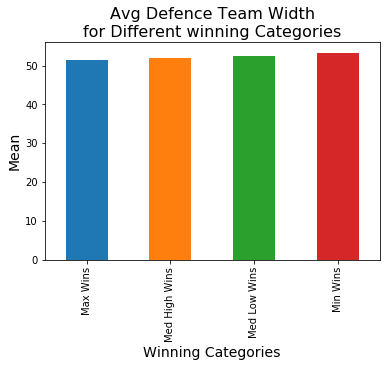

In [95]:
ax = attribs_stats.groupby('win_cats')['defenceTeamWidth'].mean().plot(kind='bar');
plt.title('Avg Defence Team Width\nfor Different winning Categories', fontsize=16)
plt.ylabel('Mean', fontsize=14)
plt.xlabel('Winning Categories', fontsize=14);
ax.set_xticklabels(['Max Wins', 'Med High Wins', 'Med Low Wins', 'Min Wins']);

This bar chart shows the Average Defence Team Width for the Different Winning Categories
>Inverse correlation can be seen

In [96]:
attribs_stats.describe()

,team,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,win,loss,draw,team_goals,oponent_goals,home,away,win_perc
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,9765.209738,52.522472,47.895131,52.444757,53.808989,54.226592,46.521536,49.641386,52.286517,13.237828,13.023408,8.886704,47.909176,47.404494,17.573034,17.574906,0.376679
std,12501.630844,11.996503,11.092702,10.519930,11.215827,10.572159,10.437950,10.029836,9.647310,5.631581,5.175859,2.972743,16.120801,13.264071,1.795888,1.798939,0.155065
min,1601.000000,20.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,30.000000,1.000000,0.000000,0.000000,5.000000,6.000000,3.000000,3.000000,0.078947
25%,8472.000000,45.000000,39.000000,46.000000,47.000000,48.750000,39.000000,44.000000,48.000000,9.000000,10.000000,7.000000,37.000000,38.750000,17.000000,17.000000,0.264706
50%,8721.000000,53.000000,49.000000,52.000000,53.000000,54.000000,46.000000,48.500000,52.000000,12.000000,13.000000,9.000000,45.000000,47.000000,18.000000,18.000000,0.342105
75%,9927.000000,63.000000,55.000000,60.000000,63.000000,63.000000,53.000000,57.000000,59.000000,16.000000,17.000000,11.000000,56.000000,56.000000,19.000000,19.000000,0.466667
max,274581.000000,80.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,33.000000,29.000000,19.000000,121.000000,98.000000,20.000000,20.000000,0.900000


### What teams improved the most over the time period?

In [97]:
compare_score.head()

,team,new_score,old_score,improvement
17,Atlético Madrid,2.184211,1.500000,0.684211
149,Paris Saint-Germain,2.309211,1.644737,0.664474
5,AS Monaco,1.894737,1.263158,0.631579
108,Juventus,2.414474,1.785235,0.629239
158,RAEC Mons,1.466667,0.859375,0.607292


We can see that Atlético Madrid, Paris Saint-Germain and AS Monaco are the teams that improved the most over the time period.

### What team attributes lead to the most victories?

In [98]:
grouped_attribs = attribs_stats.groupby('win_cats').agg({
    'buildUpPlaySpeed':'mean', 'buildUpPlayPassing':'mean', 'chanceCreationPassing':'mean', 
    'chanceCreationCrossing':'mean', 'chanceCreationShooting':'mean', 'defencePressure':'mean',
    'defenceAggression':'mean', 'defenceTeamWidth':'mean'}).reset_index()

In [99]:
grouped_attribs.head()

,win_cats,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,max_wins,52.560886,50.254613,51.815498,52.505535,53.852399,44.476015,48.730627,51.453875
1,med_high_wins,52.180723,47.550201,51.987952,52.654618,53.188755,44.803213,49.156627,51.895582
2,med_low_wins,52.610526,48.638596,52.740351,54.950877,54.245614,46.943860,49.712281,52.498246
3,min_wins,52.711027,44.984791,53.205323,55.007605,55.574144,49.798479,50.961977,53.285171


From the table above and the previous plots we can see there are three attributes that are inversely correlated with most vicotires:
1. defence pressure: Most wins are corelated with lower defence pressuer!
2. chanceCreationCrossing: Most wins are correlated with lower chance creation from corssing!
3. defenceTeamWidth: Most wins are correlated with lower defence team width!

So the answer to that question is: lower defence pressure, lower chance creation from corssing, and lower defence team width are the attributes that lead to the most victories

<a id='conclusions'></a>
## Conclusions

### It has to be clear that this data is tentative and cannot be treated as final conclusion

The data shows that teams tend to win when playing home much more than they lose or draw.

It shows also that teams tend to score slightly more goals when playing home.

Data shows also that Atlético Madrid, Paris Saint-Germain and AS Monaco are the teams that improved the most over the time 
period from seaons 2008/2009:2011/2012 to seasons 2012/2013:2015/2016

There is some inverse correlation between teams with most victories and some team attributes, namely: defence pressuer, chance creation from crossing and defence team width. looks like the less teams focus on defence the more they win.


In [100]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0